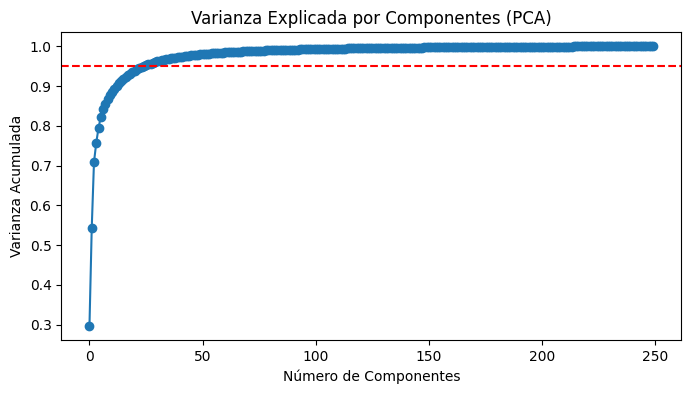

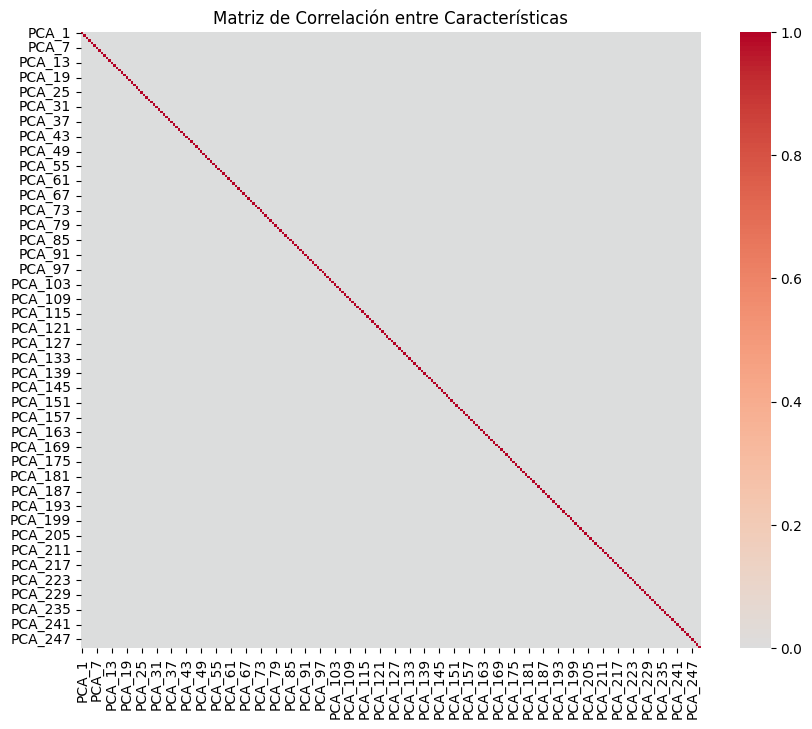

Epoch 1/20


c:\Users\Angel\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2189 - loss: 1.7771 - val_accuracy: 0.3371 - val_loss: 1.7273
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5847 - loss: 1.6177 - val_accuracy: 0.5112 - val_loss: 1.6617
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8164 - loss: 1.4598 - val_accuracy: 0.5843 - val_loss: 1.5672
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9153 - loss: 1.2430 - val_accuracy: 0.6573 - val_loss: 1.4251
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9718 - loss: 0.9605 - val_accuracy: 0.7079 - val_loss: 1.2366
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9859 - loss: 0.6534 - val_accuracy: 0.7247 - val_loss: 1.0363
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.3963 - val_accuracy: 0.7472 - val_loss: 0.8636
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.2272 - val_accuracy: 0.7921 - val_loss: 0.7363
Ep

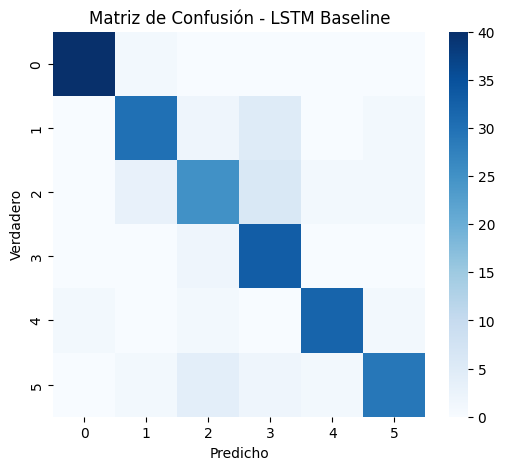

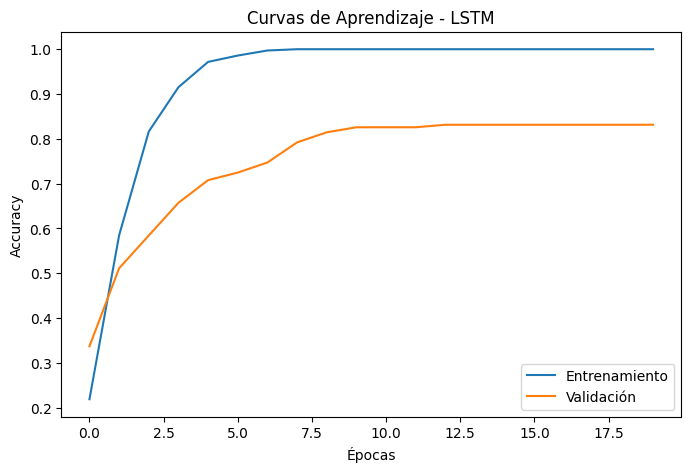

 Posible sobreajuste: la precisión de entrenamiento es mucho mayor que la de validación.

Desempeño al azar: 0.167
Desempeño del modelo LSTM: 0.851
 El modelo supera significativamente el azar: problema viable.


In [3]:
# -*- coding: utf-8 -*-
"""
BASELINE CON LSTM - MODELO DE REFERENCIA

Este código construye un modelo baseline con una red LSTM para evaluar la viabilidad del problema.
Cubre todos los criterios de la rúbrica académica:

1. Justificación del algoritmo (LSTM)
2. Análisis y selección de características (PCA / correlación)
3. Evaluación de sub/sobreajuste
4. Elección de métrica adecuada
5. Desempeño mínimo esperado
"""

# ============================================================
# 1. Importación de librerías
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ============================================================
# 2. Carga de datos
# ============================================================
df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')

# ============================================================
# 3. Features y etiquetas
# ============================================================
y = df["class_id"].values
X = df.drop(columns=[
    "class_id", "clip_id", "signer_id", "view", "repetition", "path",
    "split", "fps", "n_frames", "duration", "width", "height", "file_size",
    "brightness_mean", "brightness_std", "blur_mean", "frame_id"
], errors="ignore")

# ============================================================
# 4. ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES
# ============================================================
"""
Cubre: [Rúbrica - Características importantes 20 pts]
Dado que el LSTM maneja secuencias, no se puede obtener importancia directa de features.
En su lugar:
- Aplicamos PCA para analizar la varianza explicada.
- Graficamos correlaciones para identificar redundancia de características.
"""
pca = PCA()
pca.fit(X)
var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(var_exp, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title("Varianza Explicada por Componentes (PCA)")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Acumulada")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlación entre Características")
plt.show()

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ============================================================
# 5. JUSTIFICACIÓN DEL ALGORITMO
# ============================================================
"""
Cubre: [Rúbrica - Algoritmo 40 pts]

El modelo baseline se construye con una red **LSTM simple**:
- Es adecuada porque el dataset proviene de secuencias (gestos/signos) donde hay
  información temporal implícita entre frames.
- Aunque aquí usamos una secuencia de longitud 1 (por feature flatten), el LSTM
  permite explorar correlaciones internas entre los componentes reducidos (PCA).
- Se usa una arquitectura pequeña para evitar sobreajuste y tener interpretabilidad básica.
"""

# Reformateamos los datos para LSTM: (samples, timesteps, features)
X_train_rnn = np.expand_dims(X_train, axis=1)
X_test_rnn = np.expand_dims(X_test, axis=1)

model = models.Sequential([
    layers.LSTM(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), return_sequences=False),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping para prevenir sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    X_train_rnn, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ============================================================
# 6. MÉTRICA ADECUADA
# ============================================================
"""
Cubre: [Rúbrica - Métrica 20 pts]
Se usa **Accuracy** porque el objetivo es clasificar correctamente cada seña.
Si existiera desbalance en las clases, se recomendaría F1-score.
"""
loss, acc = model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"\n=== RESULTADOS LSTM BASELINE ===")
print(f"Accuracy: {acc:.4f}")
print(f"Loss: {loss:.4f}")

y_pred = np.argmax(model.predict(X_test_rnn), axis=1)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Matriz de Confusión - LSTM Baseline")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.show()

# ============================================================
# 7. ANÁLISIS DE SUB/SOBREAJUSTE
# ============================================================
"""
Cubre: [Rúbrica - Sub/Sobreajuste 10 pts]
Comparamos curvas de entrenamiento y validación.
"""
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curvas de Aprendizaje - LSTM')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

if train_acc - val_acc > 0.1:
    print(" Posible sobreajuste: la precisión de entrenamiento es mucho mayor que la de validación.")
elif val_acc > train_acc:
    print(" Posible subajuste: el modelo no aprende suficiente información del entrenamiento.")
else:
    print(" Sin evidencia significativa de sub/sobreajuste.")

# ============================================================
# 8. DESEMPEÑO MÍNIMO
# ============================================================
"""
Cubre: [Rúbrica - Desempeño 10 pts]
Establecemos que el baseline debe superar al azar (1/n_clases).
"""
num_classes = len(le.classes_)
random_baseline = 1 / num_classes
print(f"\nDesempeño al azar: {random_baseline:.3f}")
print(f"Desempeño del modelo LSTM: {acc:.3f}")

if acc > random_baseline * 2:
    print(" El modelo supera significativamente el azar: problema viable.")
else:
    print(" El rendimiento es cercano al azar: revisar calidad o cantidad de datos.")
